In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect 

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables

base.prepare(engine, reflect=True)

In [7]:
inspector = inspect(engine)

In [8]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector.get_table_names()

['measurement', 'station']

In [12]:
engine.execute('SELECT * FROM measurement Limit 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
engine.execute('SELECT * FROM station Limit 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [14]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precipitation = [measurement.prcp, measurement.date]

# Calculate the date 1 year ago from the last data point in the database
engine.execute('SELECT MAX(date) FROM measurement Limit 5').fetchall()
yeardate = dt.datetime(2016,8,23)
# Perform a query to retrieve the data and precipitation scores
oneyear = session.query(*precipitation).\
    filter(measurement.date >= yeardate).all()
#oneyear



In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
PrecipOneYear = pd.DataFrame(oneyear)
PrecipOneYear = PrecipOneYear.set_index("date")

# Sort the dataframe by date
PrecipOneYear.sort_values(by=['date'], ascending=True)
PrecipOneYear



,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


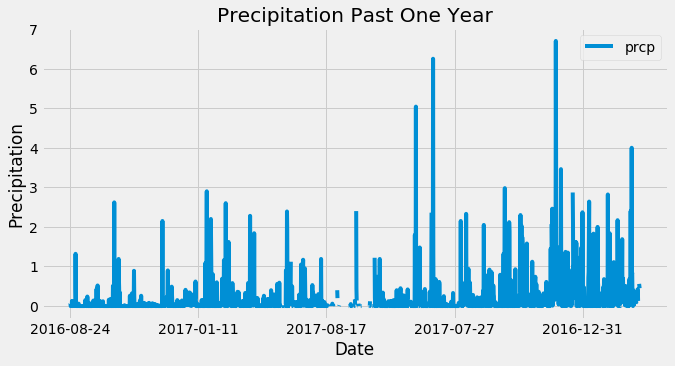

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
PrecipOneYear.plot(kind="line", figsize=(10,5))
plt.title("Precipitation Past One Year")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
PrecipOneYear.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(station.id).count()
station_count

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
newer_list=[]
for measure in session.query(measurement).filter(measurement.station=="USC00519281"):
    newer_list.append(measure.tobs)
    
#newer_list

In [23]:
len(newer_list)

2772

In [24]:
mean = np.mean(newer_list)
high = np.max(newer_list)
low = np.min(newer_list)

print(f"The min temp is: {low}")
print(f"The max temp is: {high}")
print(f"The mean temp is: {mean}")

The min temp is: 54.0
The max temp is: 85.0
The mean temp is: 71.66378066378067


In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histo_list=[]
for measure in session.query(measurement).filter(measurement.station=="USC00519281").filter(measurement.date>yeardate):
    histo_list.append(measure.tobs)
    
#histo_list

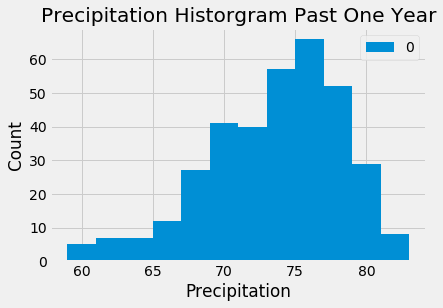

In [26]:
histo_df= pd.DataFrame(histo_list)
histo_df.plot(kind="hist",bins=12)
plt.title('Precipitation Historgram Past One Year')
plt.xlabel('Precipitation')
plt.ylabel('Count')
plt.show()